In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

In [3]:
USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: False


In [6]:
COUNT = 10000

def train_test_split(data):
    count = data.shape[0]
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

def create_two_gaussians(p, noise=0.1):
    mix = TD.Categorical(torch.tensor([p, 1 - p]))
    mv_normals = TD.MultivariateNormal(
        torch.tensor([[1., 1.], [-1., -1.]]),
        noise * torch.eye(2).unsqueeze(0).repeat_interleave(2, 0))

    if USE_CUDA:
      return TD.MixtureSameFamily(mix, mv_normals).cuda()

    return TD.MixtureSameFamily(mix, mv_normals)

In [16]:
TwoGaussMixture = create_two_gaussians(0.2)
train_data, test_data = train_test_split(TwoGaussMixture.sample((COUNT,)))

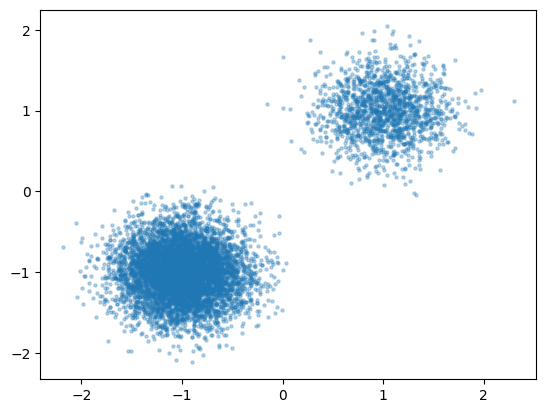

In [24]:
plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.3, s=5)
plt.show()

In [54]:
BATCH_SIZE = 64
dataset = TensorDataset(train_data) # create your datset
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [29]:
def plot_score_function(
    score_function,
    data,
    title,
    plot_scatter=True,
    xlim=(-2., 2.),
    ylim=(-2., 2.),
    npts=40,
    ax=None,
    figsize=(12, 12),
    scatter_label='GT labels',
    quiver_label = None,
    quiver_color='black'
):
    xx = np.stack(np.meshgrid(np.linspace(xlim[0], xlim[1], npts),
                              np.linspace(ylim[0], ylim[1], npts)), axis=-1).reshape(-1, 2)

    input = torch.tensor(xx).float()
    if USE_CUDA:
      scores = score_function(input.cuda()).detach().cpu().numpy()
    else:
      scores = score_function(input).detach().numpy()

    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Draw the plots
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if plot_scatter:
        ax.scatter(data[:, 0], data[:, 1], alpha=0.3, color='blue', s=5, label=scatter_label)
    ax.quiver(*xx.T, *scores_log1p.T, width=0.002, color=quiver_color, label=quiver_label)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title, fontsize=16)
    return ax

In [30]:
import torch.autograd as autograd

def batch_jacobian(input, output, create_graph=True, retain_graph=True):
    '''
    :Parameters:
    input : tensor (bs, *shape_inp)
    output: tensor (bs, *shape_oup) , NN(input)
    :Returns:
    gradient of output w.r.t. input (in batch manner), shape (bs, *shape_oup, *shape_inp)
    '''
    def out_permutation():
        n_inp = np.arange(len(input.shape) - 1)
        n_output = np.arange(len(output.shape) - 1)
        return tuple(np.concatenate([n_output + 1, [0,], n_inp + len(n_output) + 1]))

    s_output = torch.sum(output, dim=0) # sum by batch dimension
    batched_grad_outputs = torch.eye(
        np.prod(s_output.shape)).view((-1,) + s_output.shape).to(output)
    # batched_grad_outputs = torch.eye(s_output.size(0)).to(output)
    grad = autograd.grad(
        outputs=s_output, inputs=input,
        grad_outputs=batched_grad_outputs,
        create_graph=create_graph,
        retain_graph=retain_graph,
        only_inputs=True,
        is_grads_batched=True
    )
    return grad[0].permute(out_permutation())


def distribution2score(distribution):
    def score_function(x):
        x.requires_grad_(True) # (bs, 2)
        log_prob = distribution.log_prob(x).unsqueeze(-1) # (bs, 1)
        s_raw = batch_jacobian(
            x, log_prob, create_graph=False, retain_graph=False) # (bs, 1, 2)
        return s_raw.reshape(x.size(0), -1).detach()
    return score_function

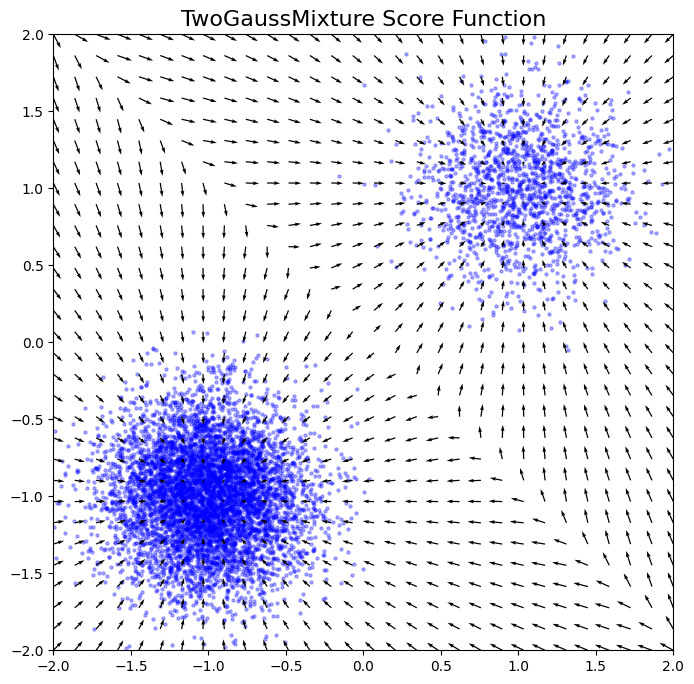

In [33]:
plot_score_function(distribution2score(TwoGaussMixture), train_data, 'TwoGaussMixture Score Function', figsize=(8, 8), npts=30)
plt.show()

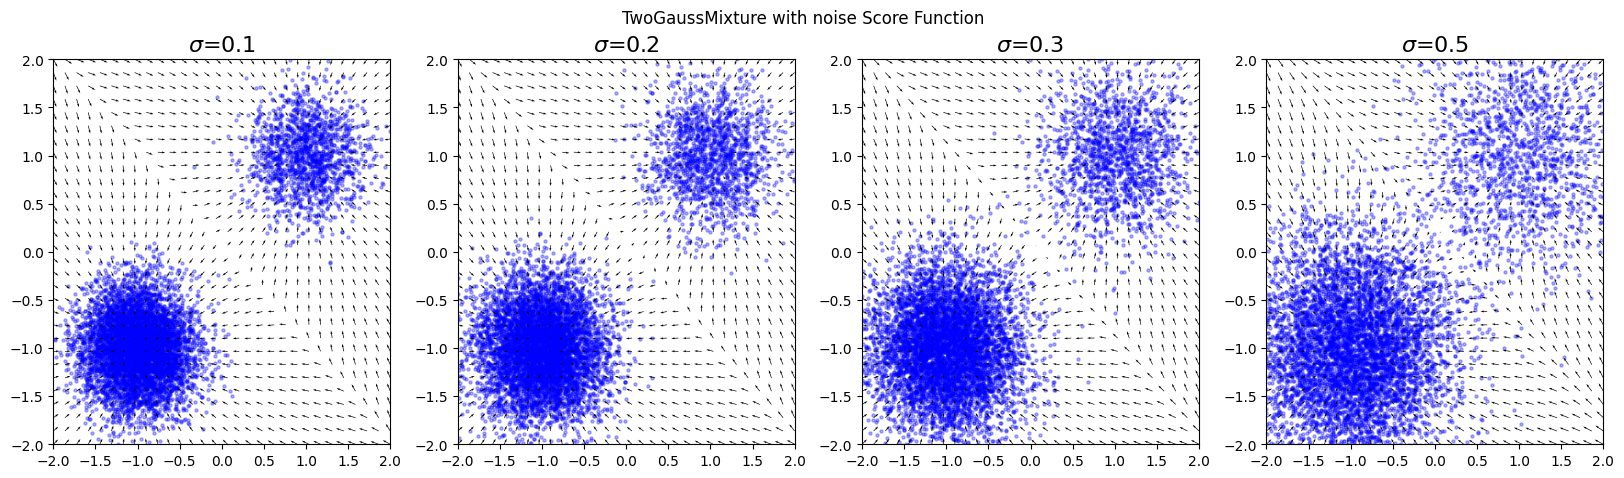

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, sigma in enumerate([0.1, 0.2, 0.3, 0.5]):
  noisy_mixture = create_two_gaussians(0.2, 0.1+sigma**2)
  noisy_data = train_data + sigma * torch.randn_like(train_data)
  plot_score_function(distribution2score(noisy_mixture), noisy_data, r'$\sigma$={}'.format(sigma), ax=ax[i], npts=30)

plt.suptitle('TwoGaussMixture with noise Score Function')
plt.show()

In [135]:
class SimpleScoreNetwork(nn.Module):
  def __init__(self, hidden_dim: int = 128, data_dim: int = 2) -> None:
    super().__init__()

    self.data_dim = data_dim

    self.layers = nn.Sequential(
                  nn.Linear(2, hidden_dim),
                  nn.Softplus(),
                  nn.Linear(hidden_dim, hidden_dim),
                  nn.Softplus(),
                  nn.Linear(hidden_dim, 2),
              )


  def forward(self, input: torch.Tensor) -> torch.Tensor:
    return self.layers(input)

  def prior(self, n_samples):
    # sample from prior distribution
    noise = torch.randn(n_samples, self.data_dim)
    if USE_CUDA:
      return noise.cuda()
    return noise

  def sample(self, n_samples: int,
             n_steps: int,
             eps: float = 0.00005,
             save_history: bool = False,
             save_freq: int = 1) -> torch.Tensor:
    #Langevin dynamics
    x_k = self.prior(n_samples)
    history = []
    alpha = eps
    with torch.no_grad():
      for k in range(n_steps):
        score = self(x_k)
        x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
        if save_history and k % save_freq == 0:
          history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

In [116]:
class NoiseConditionalScoreNetwork(nn.Module):
  def __init__(self, hidden_dim: int = 128, data_dim: int = 2, num_sigmas: int = 5) -> None:
    super().__init__()

    self.data_dim = data_dim
    self.num_sigmas = num_sigmas
    self.emb = nn.Embedding(num_sigmas, hidden_dim // 5)
    self.linear = nn.Linear(2, hidden_dim // 2)
    self.layers = nn.Sequential(
                  nn.Softplus(),
                  nn.Linear(hidden_dim // 2 + hidden_dim // 5, hidden_dim),
                  nn.Softplus(),
                  nn.Linear(hidden_dim, 2)
                  )


  def forward(self, input: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    embed = self.emb(sigma)
    output = self.linear(input)
    output = torch.cat([output, embed], dim=-1)
    return self.layers(output)

  def prior(self, n_samples):
    # sample from prior distribution
    noise = torch.randn(n_samples, self.data_dim)
    if USE_CUDA:
      return noise.cuda()
    return noise


  def sample(self, n_samples: int,
             n_steps: int,
             sigmas: torch.Tensor,
             eps: float = 0.01,
             save_history: bool = False,
             save_freq: int = 1) -> torch.Tensor:
    # annealed Langevin dynamics
    x_k = self.prior(n_samples)

    history = []
    with torch.no_grad():
      for i, sigma in enumerate(sigmas):
        alpha = eps * sigma**2 / sigmas[-1]**2
        for k in range(n_steps):
          sigma_batch = torch.ones(n_samples, device=x_k.device, dtype=torch.int) * i
          score = self(x_k, sigma_batch)
          x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
          if save_history and k % save_freq == 0:
            history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()


  def Langevin(self, n_samples: int,
               n_steps: int,
               sigmas: torch.Tensor,
               sigma_idx: int = -1,
               eps: float = 0.01,
               save_history: bool = False,
               save_freq: int = 1) -> torch.Tensor:
    #Langevin dynamics
    x_k = self.prior(n_samples)
    history = []
    if sigma_idx == -1:
      sigma_idx = self.num_sigmas - 1

    alpha = eps * sigmas[sigma_idx]**2 / sigmas[-1]**2
    sigma_batch = torch.ones(n_samples, dtype=torch.int, device=x_k.device) * sigma_idx
    with torch.no_grad():
      for k in range(n_steps):
        score = self(x_k, sigma_batch)
        x_k += alpha * score.detach() / 2 + np.sqrt(alpha) * torch.randn_like(x_k)
        if save_history and k % save_freq == 0:
          history.append(x_k.cpu())

    if save_history:
      return x_k.cpu(), history

    return x_k.cpu()

In [60]:
type(torch.Tensor([0.01])[0])

torch.Tensor

In [129]:
def train_sn(
    model: object,
    train_loader: object,
    n_epochs: int,
    lr: float,
    sigmas: torch.Tensor = torch.Tensor([0.1]),
    use_cuda: bool = False,
    conditional: bool = True
) -> dict:

  if use_cuda:
      critic = model.cuda()
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0, 0.9))

  #curr_iter = 0
  batch_loss_history = {"loss": []}
  for epoch_i in tqdm(range(n_epochs)):
    for batch_i, x in enumerate(train_loader):
      x = x[0]
      batch_size = x.shape[0]
      if use_cuda:
        x = x.cuda()


      if conditional:
        labels = torch.randint(len(sigmas), (batch_size,))
        sigma_batch = sigmas[labels].to(x.device)
        sigma_batch = sigma_batch.reshape(-1,  1)
      else:
        sigma_batch = sigmas[0] * torch.ones(batch_size, 1, device=x.device).float()

      standart_noise = torch.randn_like(x)
      x_noisy = x + standart_noise * sigma_batch


      optimizer.zero_grad()
      if conditional:
        pred_scores = model(x_noisy, labels.to(x.device))
      else:
        pred_scores = model(x_noisy)

      noisy_scores = (-standart_noise / sigma_batch)

      losses = torch.sum((pred_scores - noisy_scores)**2, axis=-1) / 2
      loss = torch.mean(losses * sigma_batch.flatten()**2)


      loss.backward()
      optimizer.step()

      batch_loss_history["loss"].append(loss.data.cpu().numpy())

    if epoch_i % 5 == 0:
      clear_output()
      plt.plot(batch_loss_history["loss"])
      plt.show()


  return batch_loss_history

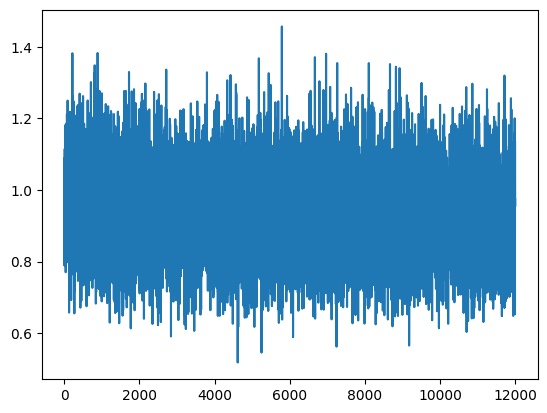

In [136]:
simple_score_net = SimpleScoreNetwork(hidden_dim=512)

losses = train_sn(model=simple_score_net,
                  train_loader=dataloader,
                  n_epochs=100,
                  sigmas=torch.Tensor([0.1]),
                  lr=1e-4,
                  conditional=False,
                  use_cuda=USE_CUDA)

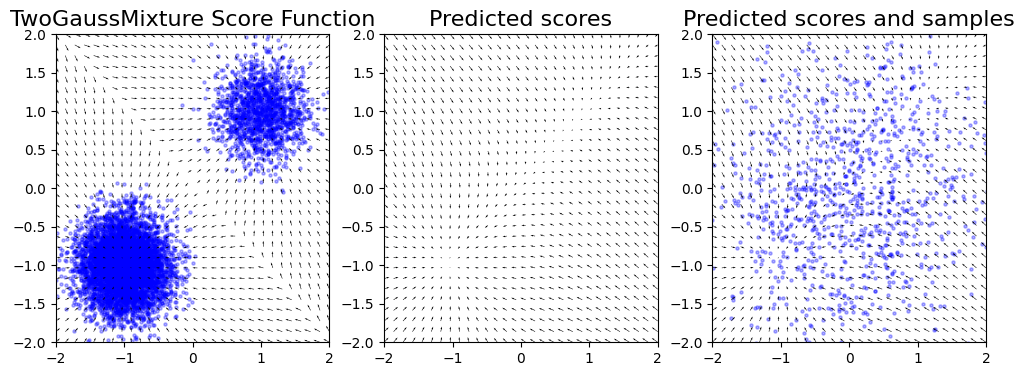

In [134]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

plot_score_function(distribution2score(TwoGaussMixture), train_data, 'TwoGaussMixture Score Function', ax=ax[0], npts=30)

samples = simple_score_net.sample(1000, 100, eps=0.0001)
plot_score_function(simple_score_net, samples, 'Predicted scores', ax=ax[1], npts=30, plot_scatter=False)

plot_score_function(simple_score_net, samples, 'Predicted scores and samples', ax=ax[2], npts=30)

plt.show()

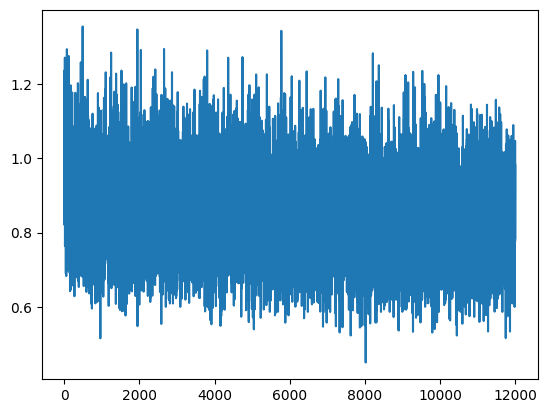

In [117]:
num_sigmas = 5
sigmas = torch.tensor(np.exp(np.linspace(np.log(0.5), np.log(0.01), num_sigmas))).float()

conditional_score_net = NoiseConditionalScoreNetwork(hidden_dim=512)

losses = train_sn(model=conditional_score_net,
                  train_loader=dataloader,
                  n_epochs=100,
                  lr=1e-4,
                  sigmas=sigmas,
                  conditional=True,
                  use_cuda=USE_CUDA)

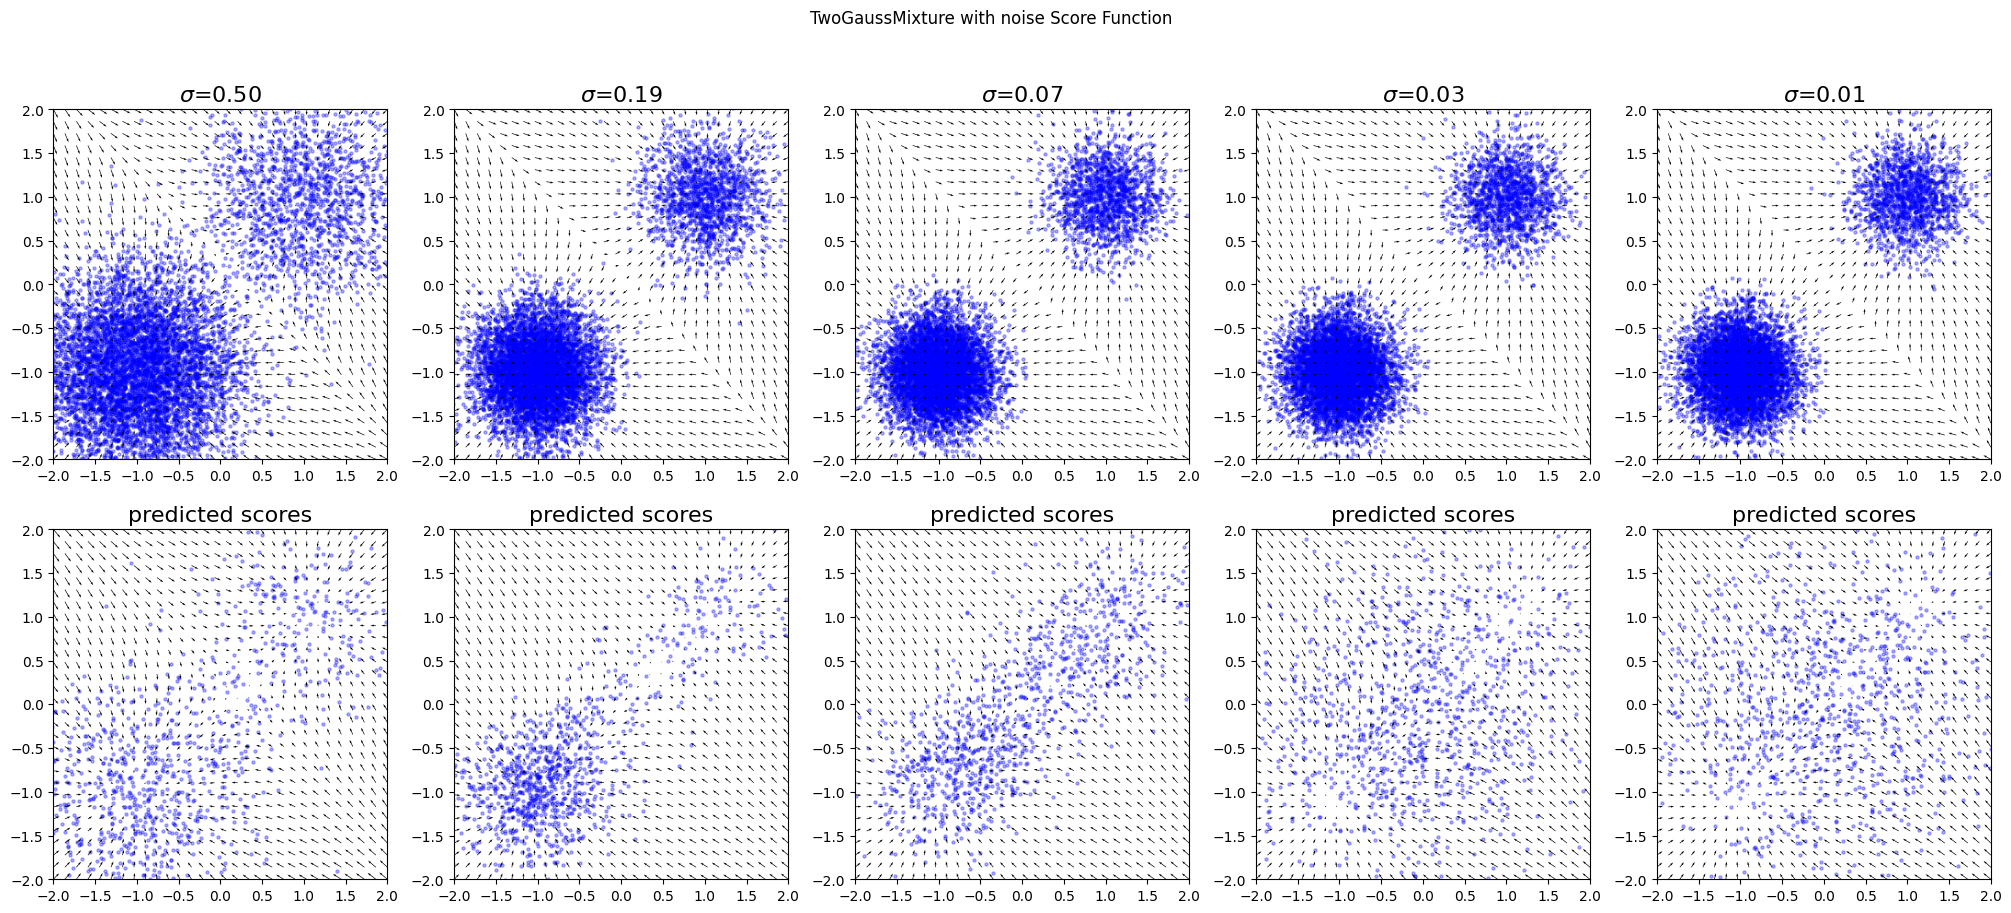

In [118]:
fig, ax = plt.subplots(2, len(sigmas), figsize=(25, 10))
for i, sigma in enumerate(sigmas):
  noisy_mixture = create_two_gaussians(0.2, 0.1+sigma**2)
  noisy_data = train_data + sigma * torch.randn_like(train_data)
  plot_score_function(distribution2score(noisy_mixture), noisy_data, r'$\sigma$={:.2f}'.format(sigma), ax=ax[0][i], npts=30)

  samples = conditional_score_net.Langevin(1000, 100, sigmas, sigma_idx=i, eps=0.0001)
  pred_scores = lambda x: conditional_score_net(x, torch.ones(x.shape[0], dtype=torch.int, device=x.device)*i)
  plot_score_function(pred_scores, samples, 'predicted scores', ax=ax[1][i], npts=30)

plt.suptitle('TwoGaussMixture with noise Score Function')
plt.show()

In [119]:
samples = conditional_score_net.sample(1000, 100, sigmas, eps=0.0001)

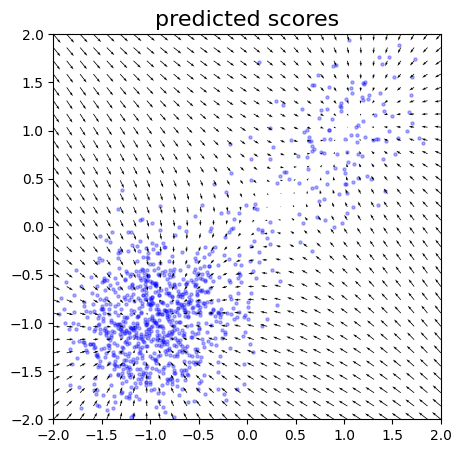

In [120]:
plot_score_function(pred_scores, samples, 'predicted scores', npts=30, figsize=(5, 5));